In [1]:
from keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling="avg")

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

def get_image(fname, show=False):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    img = cv2.resize(img, (224, 224))
    #img = np.swapaxes(img, 0, 2)
    #img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    
    #img = img.astype('float32') / 255.
    
    return img

In [3]:
import glob
import os

def process_files(folder_name, start_index=0):
    
    products = []
    index = start_index
    dim = 2048
    xb = np.empty(shape=[0, dim], dtype=np.float32)
    
    for imgfolderpath in glob.glob(folder_name + '/*'):
        productTitle = os.path.basename(imgfolderpath)
    
        for file in glob.glob(imgfolderpath + '/*'):
        #with open(file_name) as file:
        #for line in file:
            try:
                img = get_image(file)
                product = {}
                #fields = line.split(',')
                product['id'] = str(index)
                product['productTitle'] = productTitle #fields[0].strip()
                product['imageUrl'] = file #fields[1].strip()
                # download image to be featurized and preprocess it
                #file = mx.test_utils.download(product['imageUrl'])
                product['imageFileName'] = file
                # extract features

                features_batch = model.predict([img])
                features = features_batch[0]

                # the Knn algorithm we'll use requires float32 rather than the default float64
                xb = np.append(xb, [features.astype(np.float32)], axis=0)

                products.append(product)
                index += 1
            except:
                print("Something went wrong with the file: " + file)            
    return (products, xb)

In [10]:
#products, train_features = process_files('/dataset/10classes')
products, train_features = process_files('/solutions/transfer-learning-anime/cropped')

In [5]:
import sklearn
import sklearn.preprocessing

In [13]:
train_features = sklearn.preprocessing.normalize(train_features)

In [14]:
Y = []
for product in products:
    Y.append(product['productTitle'])

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics                


x_train, x_test, y_train, y_test = train_test_split(train_features, Y, test_size=0.2, random_state=42)

n=50
acc_array=np.zeros(n)
for k in np.arange(1,n+1,1): # here k will take values from 1 to n
    classifier = KNeighborsClassifier(n_neighbors=k,weights='distance').fit(x_train,y_train) # k changes after each iteration
    y_pred = classifier.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    acc_array[k-1]=acc # store correctly the results
    print("Accuracy=", acc, " with k=", k)

Accuracy= 0.9090909090909091  with k= 1
Accuracy= 0.9090909090909091  with k= 2
Accuracy= 0.9090909090909091  with k= 3
Accuracy= 0.9545454545454546  with k= 4
Accuracy= 0.9090909090909091  with k= 5
Accuracy= 0.9090909090909091  with k= 6
Accuracy= 0.9090909090909091  with k= 7
Accuracy= 0.9545454545454546  with k= 8
Accuracy= 0.9090909090909091  with k= 9
Accuracy= 0.9545454545454546  with k= 10
Accuracy= 0.9090909090909091  with k= 11
Accuracy= 0.9545454545454546  with k= 12
Accuracy= 0.9545454545454546  with k= 13
Accuracy= 0.9545454545454546  with k= 14
Accuracy= 0.9545454545454546  with k= 15
Accuracy= 0.9545454545454546  with k= 16
Accuracy= 0.9545454545454546  with k= 17
Accuracy= 0.9545454545454546  with k= 18
Accuracy= 0.9545454545454546  with k= 19
Accuracy= 0.9545454545454546  with k= 20
Accuracy= 0.9545454545454546  with k= 21
Accuracy= 0.9545454545454546  with k= 22
Accuracy= 0.9545454545454546  with k= 23
Accuracy= 0.9545454545454546  with k= 24
Accuracy= 0.9545454545454

In [16]:
max_acc=np.amax(acc_array)
acc_list=list(acc_array)
k=acc_list.index(max_acc)+1
print("The best accuracy was with ", max_acc, " with k=", k)

The best accuracy was with  1.0  with k= 39


In [10]:
#########################################

In [9]:
neigh = KNeighborsClassifier(n_neighbors=5,weights='distance')
neigh.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [10]:
proba = neigh.predict_proba(x_test)

In [21]:
proba[3]

array([0.41428517, 0.        , 0.58571483, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [27]:
import pandas as pd

In [52]:
#prob = pd.DataFrame(np.column_stack([neigh.classes_, proba[3]]))
#prob.sort_values(1,ascending=False,inplace=True)
#prob

prob = pd.DataFrame(neigh.classes_)
prob[1] = proba[3]
prob.sort_values(1,ascending=False,inplace=True)
prob


,0,1
2,Bolts,0.585715
0,Aircrafts,0.414285
1,Balls,0.000000
3,Bubbles,0.000000
4,Crack,0.000000
5,Crumb,0.000000
6,Cylinder,0.000000
7,MarkingLines,0.000000
8,Nuts,0.000000
9,Spots,0.000000


In [53]:
[
        {
            'human_string': row[0],
            'score': row[1],
        }
        for (_, row) in prob.iterrows() if row[1] > 0
]


[{'human_string': 'Bolts', 'score': 0.5857148264494385},
 {'human_string': 'Aircrafts', 'score': 0.4142851735505615}]

In [24]:
y_test[3]


'Aircrafts'

In [13]:
neigh.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [17]:
neigh.classes_

array(['Aircrafts', 'Balls', 'Bolts', 'Bubbles', 'Crack', 'Crumb',
       'Cylinder', 'MarkingLines', 'Nuts', 'Spots'], dtype='<U12')

In [37]:
pred = neigh.predict(x_test)

In [38]:
dict = {}
ok = 0
for index, v in enumerate(pred):
    expected = y_test[index]
    if (expected == v):
        ok = ok + 1
    if expected not in dict:
        dict[expected] = {}
    if v not in dict[expected]:
        dict[expected][v] = 1
    else:
        dict[expected][v] = dict[expected][v] + 1

In [39]:
import pandas as pd

dfObj = pd.DataFrame(dict)

dfObj = dfObj.reindex(sorted(dfObj.columns), axis=1)

# Transpose dataframe object
dfObj = dfObj.transpose()

dfObj = dfObj.reindex(sorted(dfObj.columns), axis=1)

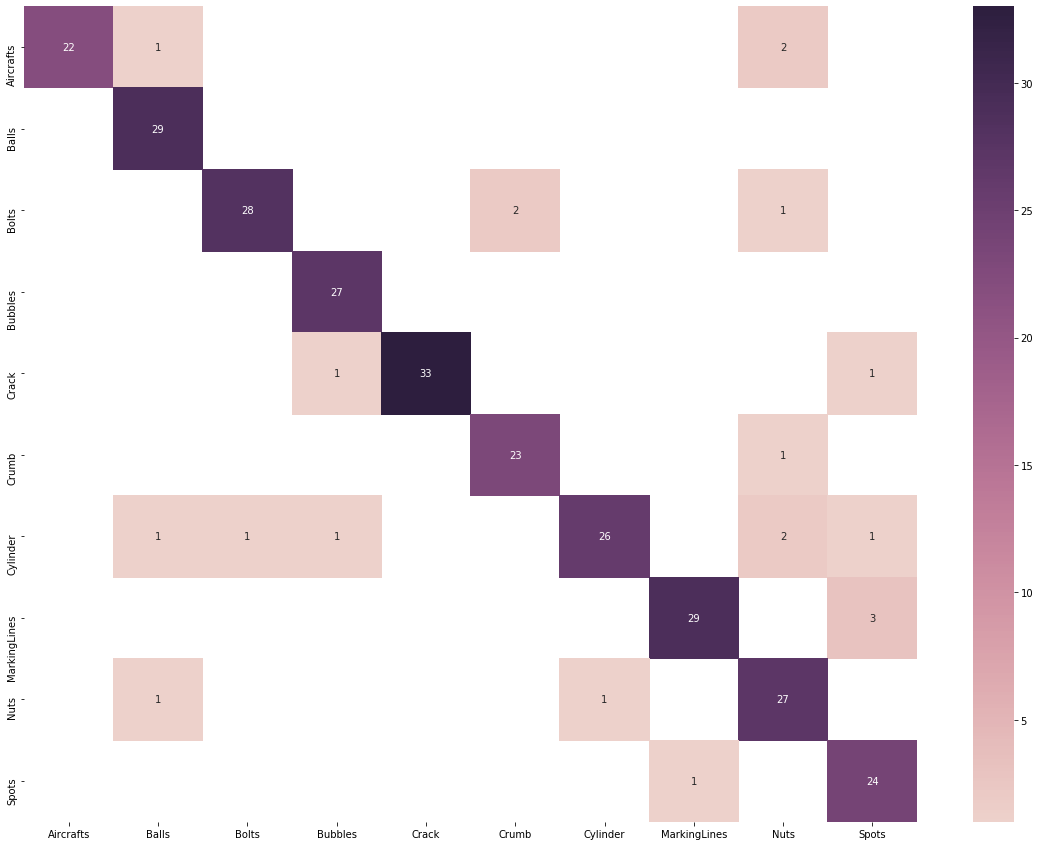

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,15))
_ = sns.heatmap(dfObj, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax, fmt='g')

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3).fit_transform(train_features)

In [44]:
df = pd.DataFrame(products)
texts = df["imageFileName"]

In [45]:
texts

0       /dataset/10classes\Aircrafts\00002_011_1_1_000...
1       /dataset/10classes\Aircrafts\00002_011_1_1_000...
2       /dataset/10classes\Aircrafts\00002_011_1_1_000...
3       /dataset/10classes\Aircrafts\00002_011_1_1_000...
4       /dataset/10classes\Aircrafts\00002_011_3_1_000...
                              ...                        
1437           /dataset/10classes\Spots\Screenshot_94.jpg
1438           /dataset/10classes\Spots\Screenshot_95.jpg
1439           /dataset/10classes\Spots\Screenshot_97.jpg
1440           /dataset/10classes\Spots\Screenshot_98.jpg
1441           /dataset/10classes\Spots\Screenshot_99.jpg
Name: imageFileName, Length: 1442, dtype: object

In [65]:
#li = li = pd.Categorical(df['productTitle'])
li, uniques = pd.factorize(df['productTitle'])

In [67]:
len(uniques)

10

In [70]:
li = (li * 99) // (len(uniques) - 1)

In [71]:
li

array([ 0,  0,  0, ..., 99, 99, 99], dtype=int64)

In [56]:
import plotly.graph_objs as go

In [60]:
del dict

In [62]:
from plotly.offline import plot

In [63]:
scatter = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    text=texts,
    marker=dict(
        size=8,
        color=li,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ))

fig = go.Figure(data=[scatter])

plot(fig, filename='3d-scatter.html')

'3d-scatter.html'